In [2]:
import gymnasium as gym
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import highway_env


In [3]:
with open("config/1-highway-discrete-config.pkl", "rb") as f:
    config = pickle.load(f)

env = gym.make("highway-fast-v0", render_mode="human")
env.unwrapped.configure(config)
observation, _ = env.reset()

In [4]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=1.0):
        self.q_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.replay_buffer = deque(maxlen=100000)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 64

        self.action_dim = action_dim

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return self.q_net(state).argmax().item()

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        q_values = self.q_net(states).gather(1, actions)
        with torch.no_grad():
            max_next_q = self.target_net(next_states).max(1, keepdim=True)[0]
            target = rewards + self.gamma * (1 - dones) * max_next_q

        loss = F.mse_loss(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [6]:
def train(agent, env, episodes=1000, sync_target_every=10):
    all_rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        state = state.flatten()  # Adapter si besoin
        total_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = next_state.flatten()
            done = terminated or truncated

            agent.replay_buffer.append((state, action, reward, next_state, done))
            agent.update()

            state = next_state
            total_reward += reward

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        all_rewards.append(total_reward)

        if ep % sync_target_every == 0:
            agent.target_net.load_state_dict(agent.q_net.state_dict())

        if ep % 10 == 0:
            print(f"Episode {ep}: Reward = {total_reward:.2f}")

    return all_rewards


In [7]:
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance")
    plt.show()


Episode 0: Reward = 13.01
Episode 10: Reward = 5.21
Episode 20: Reward = 7.60
Episode 30: Reward = 18.28
Episode 40: Reward = 32.48
Episode 50: Reward = 49.43
Episode 60: Reward = 22.09
Episode 70: Reward = 5.34
Episode 80: Reward = 4.44
Episode 90: Reward = 32.44
Episode 100: Reward = 1.97
Episode 110: Reward = 3.37
Episode 120: Reward = 16.28
Episode 130: Reward = 2.00
Episode 140: Reward = 8.20
Episode 150: Reward = 20.66
Episode 160: Reward = 3.20
Episode 170: Reward = 16.36
Episode 180: Reward = 18.91
Episode 190: Reward = 21.83
Episode 200: Reward = 9.16
Episode 210: Reward = 2.31
Episode 220: Reward = 51.60
Episode 230: Reward = 26.14
Episode 240: Reward = 49.59
Episode 250: Reward = 10.46
Episode 260: Reward = 5.41
Episode 270: Reward = 8.39
Episode 280: Reward = 3.51
Episode 290: Reward = 44.97
Episode 300: Reward = 43.62
Episode 310: Reward = 53.93
Episode 320: Reward = 15.38
Episode 330: Reward = 49.07
Episode 340: Reward = 51.16
Episode 350: Reward = 50.21
Episode 360: Rewa

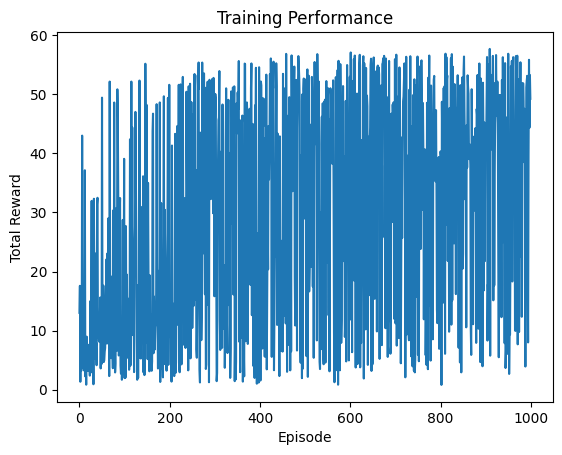

In [8]:
# Fonction principale
if __name__ == "__main__":
    # Détermination de la dimension de l'état et de celle de l'action
    state_dim = observation.flatten().shape[0]
    action_dim = env.action_space.n

    # Initialisation de l'agent
    agent = DQNAgent(state_dim, action_dim)

    # Lancement de l'entraînement
    rewards = train(agent, env, episodes=1000, sync_target_every=10)

    # Affichage des résultats
    plot_rewards(rewards)